In [9]:
#import required libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from PIL import Image
import cv2
import os

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout
from keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Conv2D, MaxPooling2D, Dropout, Flatten
from tensorflow.keras.layers import Dropout, Flatten
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard

In [2]:
# load train data
train_df = pd.read_csv('/kaggle/input/planets-dataset/planet/planet/train_classes.csv')
train_df.head()

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


In [6]:
# Creating an empty set to store the tags
tags = set()

# Iterating over each row of the train_df DataFrame and splitting the tags column
train_df['tags'].apply(lambda x: tags.update(x.split()))

# Converting the set of tags to a list
tags = list(tags)

# Printing the list of tags
print(len(tags))
print(tags)

17
['bare_ground', 'haze', 'artisinal_mine', 'cultivation', 'cloudy', 'slash_burn', 'agriculture', 'selective_logging', 'primary', 'partly_cloudy', 'blooming', 'conventional_mine', 'road', 'habitation', 'clear', 'water', 'blow_down']


In [8]:
##One hot encode the labels(tags) in train classes
for tag in tags:
    train_df[tag] = train_df['tags'].apply(lambda x: 1 if tag in x.split() else 0)
    
## adding .jpg extension to the column image_name so as to have same name format as the image files
train_df['image_name'] = train_df['image_name'].apply(lambda x: '{}.jpg'.format(x))
train_df.head(3)

,image_name,tags,bare_ground,haze,artisinal_mine,cultivation,cloudy,slash_burn,agriculture,selective_logging,primary,partly_cloudy,blooming,conventional_mine,road,habitation,clear,water,blow_down
0,train_0.jpg,haze primary,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
1,train_1.jpg,agriculture clear primary water,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,1,0
2,train_2.jpg,clear primary,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0


In [ ]:
# Histogram of label instances
train_df[tags].sum().sort_values(ascending=False).plot.bar();

In [10]:
# tags that were encoded.
column_tags = train_df.columns[2:]
column_tags

Index(['bare_ground', 'haze', 'artisinal_mine', 'cultivation', 'cloudy',
       'slash_burn', 'agriculture', 'selective_logging', 'primary',
       'partly_cloudy', 'blooming', 'conventional_mine', 'road', 'habitation',
       'clear', 'water', 'blow_down'],
      dtype='object')

In [12]:
#initialize imagedatagenerator
train_image_gen = ImageDataGenerator(rescale = 1/255, validation_split = 0.2)

#train data generator(80% of the train dataset)
#the generator contains both features and target of the data
train_generator = train_image_gen.flow_from_dataframe(dataframe=train_df,
                                                directory ="/kaggle/input/planets-dataset/planet/planet/train-jpg/",  
                                                x_col='image_name', y_col=column_tags, subset="training", 
                                                batch_size=16,seed=42, shuffle=True, 
                                                class_mode="raw", target_size=(64, 64))

#generating validation data which is expected to be 20% of the train dataset since validation split is 0.2
val_generator = train_image_gen.flow_from_dataframe(dataframe=train_df,
                                                directory ="/kaggle/input/planets-dataset/planet/planet/train-jpg/",  
                                                x_col='image_name', y_col=column_tags, subset="validation", 
                                                batch_size=16,seed=42, shuffle=True, 
                                                class_mode="raw", target_size=(64, 64))

Found 32384 validated image filenames.
Found 8095 validated image filenames.


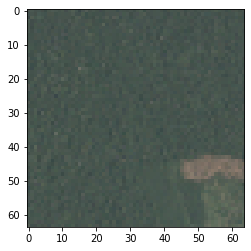

[[0 0 0 1 0 0 1 0 1 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0]
 [0 1 0 0 0 0 1 0 1 0 0 0 0 0 0 1 0]
 [0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 1 0 0 0 1 1 1 0 0]
 [0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 1 0 0 0 0 0 1 0 0]
 [0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 1 0]
 [0 0 0 1 0 0 0 0 1 0 0 0 0 0 1 1 0]
 [0 0 0 0 0 0 1 0 1 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 0 1 0 0 0 1 0 1 0 0]
 [0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 1 0 0 0 0 0 1 1 0]]


In [13]:
# Get a batch of images and labels from the train set
batch_images, batch_labels = next(train_generator)

# Preview the first image in the batch
plt.imshow(batch_images[0])
plt.show()

# Print the labels of the batch
print(batch_labels)

In [ ]:
#setting up step size for training and validation image data
# step_train_size = int(np.ceil(train_generator.samples / train_generator.batch_size))
# step_val_size = int(np.ceil(val_generator.samples / val_generator.batch_size))

In [11]:
#metrics : custom function f1_score
def f1_score(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_score = 2 * (precision * recall) / (precision + recall + K.epsilon())
    return f1_score

In [19]:
# build the model
model = Sequential()
#model.add(BatchNormalization(input_shape=(64, 64, 3)))
model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(64, 64, 3)))
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(128, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(256, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(Conv2D(256, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(17, activation='softmax'))

optim = Adam(learning_rate=1e-4)
# binary used since categorical_crossentropy l1 norms the output before calculating loss.
model.compile(loss='binary_crossentropy', optimizer=optim, metrics=f1_score)

result = model.fit(x = train_generator, validation_data = val_generator, epochs = 10)

Epoch 1/10
2024/2024 [==============================] - 445s 219ms/step - loss: 0.2364 - f1_score: 0.4380 - val_loss: 0.1949 - val_f1_score: 0.4413
Epoch 2/10
2024/2024 [==============================] - 392s 193ms/step - loss: 0.1814 - f1_score: 0.4535 - val_loss: 0.1645 - val_f1_score: 0.4433
Epoch 3/10
2024/2024 [==============================] - 386s 191ms/step - loss: 0.1606 - f1_score: 0.4589 - val_loss: 0.1549 - val_f1_score: 0.4510
Epoch 4/10
2024/2024 [==============================] - 384s 190ms/step - loss: 0.1506 - f1_score: 0.4660 - val_loss: 0.1418 - val_f1_score: 0.4730
Epoch 5/10
2024/2024 [==============================] - 383s 189ms/step - loss: 0.1434 - f1_score: 0.4726 - val_loss: 0.1342 - val_f1_score: 0.4738
Epoch 6/10
2024/2024 [==============================] - 388s 192ms/step - loss: 0.1382 - f1_score: 0.4752 - val_loss: 0.1353 - val_f1_score: 0.4744
Epoch 7/10
2024/2024 [==============================] - 382s 189ms/step - loss: 0.1342 - f1_score: 0.4786 - val_

In [20]:
# Fuction to plot loss and metrics vs number of epochs with train and validation sets
def visualize_training_results(results):
    history = results.history
    
    # create two axis objects side by side
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15,5))
    
    # plot loss on the first axis
    ax1.plot(history['val_loss'])
    ax1.plot(history['loss'])
    ax1.legend(['val_loss', 'loss'], loc='upper left', fontsize=9)
    ax1.set_title('Loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    
    # plot recall and f1 score metrics on the second axis
    ax2.plot(history['val_f1_score'])
    ax2.plot(history['f1_score'])
    ax2.legend(['val_f1_score','f1_score'], loc='upper left', fontsize=9)
    ax2.set_title('F1 score metrics')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('F1 score metrics')
    
    # display the plots
    plt.show() 

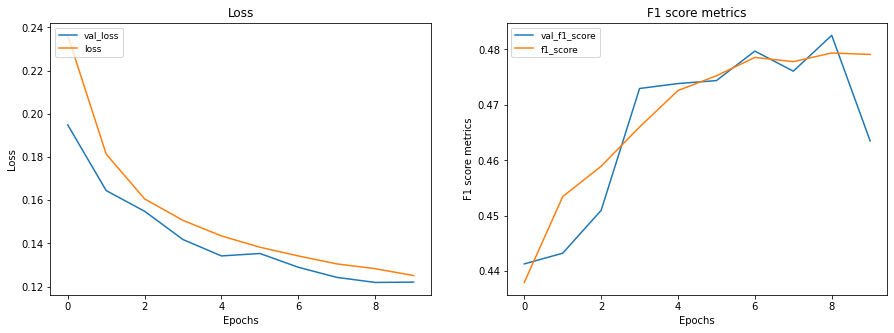

In [21]:
visualize_training_results(result)

In [22]:
#add .jpg extension to image name in the sample submission file
sub = pd.read_csv('/kaggle/input/planets-dataset/planet/planet/sample_submission.csv')
sub = sub.copy()
sub['image_name'] = sub['image_name'].apply(lambda x: '{}.jpg'.format(x))
sub.head()

,image_name,tags
0,test_0.jpg,primary clear agriculture road water
1,test_1.jpg,primary clear agriculture road water
2,test_2.jpg,primary clear agriculture road water
3,test_3.jpg,primary clear agriculture road water
4,test_4.jpg,primary clear agriculture road water


In [23]:
# test1_df has the first 40669 images 
test1_df = sub.iloc[:40669]['image_name'].reset_index().drop('index', axis =1)
test1_df.head()

,image_name
0,test_0.jpg
1,test_1.jpg
2,test_2.jpg
3,test_3.jpg
4,test_4.jpg


In [24]:
#initialize imagedatagenerator for the test images, and rescale the images
test_image_gen = ImageDataGenerator(rescale = 1/255)


#generator for the images found in the first test image files
test_generator = test_image_gen.flow_from_dataframe(dataframe=test1_df, 
                                                directory="/kaggle/input/planets-dataset/planet/planet/test-jpg", 
                                                x_col="image_name", y_col=None, batch_size=16, 
                                                shuffle=False, class_mode=None, target_size=(64, 64))

Found 40669 validated image filenames.


In [26]:
#predict the labels
test_generator.reset()
pred1 = model.predict(test_generator,  verbose = 1)

2542/2542 [==============================] - 292s 115ms/step


In [29]:
#the filenames in the generator
file_names1 = test_generator.filenames

#convert the predicted values to a dataframe and join two labels together  
#if the probability of occurrance of the label is greater than 0.5 
pred_tags1 = pd.DataFrame(pred1)
pred_tags1 = pred_tags1.apply(lambda x: ' '.join(np.array(tags)[x>0.5]), axis = 1)

#then the result should look like this 
result1 = pd.DataFrame({'image_name': file_names1, 'tags': pred_tags1})
result1.head()

,image_name,tags
0,test_0.jpg,primary
1,test_1.jpg,primary
2,test_2.jpg,partly_cloudy
3,test_3.jpg,primary
4,test_4.jpg,


In [30]:
#second batch of the test dataset
test2_df = sub.iloc[40669:]['image_name'].reset_index().drop('index', axis =1)
test2_df.head()

,image_name
0,file_0.jpg
1,file_1.jpg
2,file_10.jpg
3,file_100.jpg
4,file_1000.jpg


In [31]:
#creating a generator for the second batch of test image files
test_generator2 = test_image_gen.flow_from_dataframe(dataframe=test2_df, 
                                                directory="/kaggle/input/planets-dataset/test-jpg-additional/test-jpg-additional", 
                                                x_col="image_name", y_col=None, batch_size=16, 
                                                shuffle=False, class_mode=None, target_size=(128,128))

step_test_size2 = int(np.ceil(test_generator2.samples/test_generator2.batch_size))

Found 20522 validated image filenames.


In [32]:
#predict
test_generator2.reset()
pred2 = model.predict(test_generator2, steps = step_test_size2, verbose = 1)

1283/1283 [==============================] - 256s 199ms/step


In [33]:
file_names2 = test_generator2.filenames
pred_tags2 = pd.DataFrame(pred2)
pred_tags2 = pred_tags2.apply(lambda x: ''.join(np.array(tags)[x>0.5]), axis = 1)

#then the result should look like this
result2 = pd.DataFrame({'image_name': file_names2, 'tags': pred_tags2})
result2.head()

ValueError: array length 20522 does not match index length 184698

In [ ]:
#we need to concat the first and second results in 
#that order to avoid shuffling the index
last_result = pd.concat([result1, result2])

last_result = last_result.reset_index().drop('index', axis =1)

print(last_result.shape)
#print the final result
last_result.head()

In [ ]:
#Removing the .jpg extension from the image_name of the last_result which was added for ease of manipulation of the data.
last_result['image_name'] = last_result['image_name'].apply(lambda x: x[:-4])
last_result.head()

In [ ]:
# #Finally, we save the result to a csv file using the .to_csv() method and setting the index to false.
last_result.to_csv('submission3.csv', index = False)

In [ ]:
results_1

In [ ]:
last_result.to_csv('submission3.csv', index = False)